In [1]:
# import relevant packages / modules
import pandas as pd
import numpy as np
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

import warnings
warnings.filterwarnings("ignore")

In [2]:
# read in the dataset
filename = 'Superstore Sales Dataset.csv'
data = pd.read_csv(filename, parse_dates = ['Ship Date', 'Order Date'], dayfirst = True)

In [3]:
# have an understanding of the dataset - column names, data types, missing values, etc.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9800 non-null   int64         
 1   Order ID       9800 non-null   object        
 2   Order Date     9800 non-null   datetime64[ns]
 3   Ship Date      9800 non-null   datetime64[ns]
 4   Ship Mode      9800 non-null   object        
 5   Customer ID    9800 non-null   object        
 6   Customer Name  9800 non-null   object        
 7   Segment        9800 non-null   object        
 8   Country        9800 non-null   object        
 9   City           9800 non-null   object        
 10  State          9800 non-null   object        
 11  Postal Code    9789 non-null   float64       
 12  Region         9800 non-null   object        
 13  Product ID     9800 non-null   object        
 14  Category       9800 non-null   object        
 15  Sub-Category   9800 n

In [4]:
# have a look at the first 5 rows of the dataset
data.head()

Row ID        Order ID Order Date  Ship Date       Ship Mode Customer ID  \
0       1  CA-2017-152156 2017-11-08 2017-11-11    Second Class    CG-12520   
1       2  CA-2017-152156 2017-11-08 2017-11-11    Second Class    CG-12520   
2       3  CA-2017-138688 2017-06-12 2017-06-16    Second Class    DV-13045   
3       4  US-2016-108966 2016-10-11 2016-10-18  Standard Class    SO-20335   
4       5  US-2016-108966 2016-10-11 2016-10-18  Standard Class    SO-20335   

     Customer Name    Segment        Country             City       State  \
0      Claire Gute   Consumer  United States        Henderson    Kentucky   
1      Claire Gute   Consumer  United States        Henderson    Kentucky   
2  Darrin Van Huff  Corporate  United States      Los Angeles  California   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale     Florida   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale     Florida   

   Postal Code Region       Product ID         Category Sub-Category  \
0      42420.0  South  FUR-BO-10001798        Furniture    Bookcases   
1      42420.0  South  FUR-CH-10000454        Furniture       Chairs   
2      90036.0   West  OFF-LA-10000240  Office Supplies       Labels   
3      33311.0  South  FUR-TA-10000577        Furniture       Tables   
4      33311.0  South  OFF-ST-10000760  Office Supplies      Storage   

                                        Product Name     Sales  
0                  Bush Somerset Collection Bookcase  261.9600  
1  Hon Deluxe Fabric Upholstered Stacking Chairs,...  731.9400  
2  Self-Adhesive Address Labels for Typewriters b...   14.6200  
3      Bretford CR4500 Series Slim Rectangular Table  957.5775  
4                     Eldon Fold 'N Roll Cart System   22.3680

In [5]:
# create a new DF with only the ship date and sales in preparation for doing the forecasting using FBProphet
df1 = data[['Ship Date', 'Sales']]
df1.sample(3)

Ship Date     Sales
2876 2017-01-23  1013.488
1124 2015-01-26     6.630
7609 2018-05-07    22.960

In [6]:
# rename the columns to ds (datetime object) and y (target)
df1.columns = ['ds', 'y']
df1.head()

ds         y
0 2017-11-11  261.9600
1 2017-11-11  731.9400
2 2017-06-16   14.6200
3 2016-10-18  957.5775
4 2016-10-18   22.3680

In [7]:
# as noted above, there are more than 1 transactions for 1 ship date (i.e. not unique), thus, we need to group the sales by ship date
sales_grouped = df1.groupby(['ds'], as_index=False, dropna=False).agg({'y':'sum'})
sales_grouped.head()

ds         y
0 2015-01-07    29.228
1 2015-01-08   307.500
2 2015-01-10  4374.880
3 2015-01-12   106.694
4 2015-01-13    40.544

In [8]:
# calling on the Prophet model and fit to the DF
m = Prophet()
model_total = m.fit(sales_grouped)

15:06:30 - cmdstanpy - INFO - Chain [1] start processing
15:06:30 - cmdstanpy - INFO - Chain [1] done processing


In [9]:
# making predictions into the future and have a look at the 1st 5 predictions 
future_total = m.make_future_dataframe(periods = 60, freq = 'D')
forecast_total = m.predict(future_total)
forecast_total.head()

ds        trend   yhat_lower   yhat_upper  trend_lower  trend_upper  \
0 2015-01-07  1323.284935 -1688.872538  3784.908537  1323.284935  1323.284935   
1 2015-01-08  1323.561185 -1431.593450  3656.460020  1323.561185  1323.561185   
2 2015-01-10  1324.113683 -1583.118506  3634.218405  1324.113683  1324.113683   
3 2015-01-12  1324.666182 -1726.822543  3415.666313  1324.666182  1324.666182   
4 2015-01-13  1324.942431 -2319.042313  2882.398668  1324.942431  1324.942431   

   additive_terms  additive_terms_lower  additive_terms_upper      weekly  \
0     -234.861743           -234.861743           -234.861743  -34.760018   
1     -162.936203           -162.936203           -162.936203  107.112841   
2     -227.933923           -227.933923           -227.933923  169.615481   
3     -342.449104           -342.449104           -342.449104  160.715863   
4    -1001.441557          -1001.441557          -1001.441557 -455.312089   

   weekly_lower  weekly_upper      yearly  yearly_lower  yearly_upper  \
0    -34.760018    -34.760018 -200.101724   -200.101724   -200.101724   
1    107.112841    107.112841 -270.049044   -270.049044   -270.049044   
2    169.615481    169.615481 -397.549403   -397.549403   -397.549403   
3    160.715863    160.715863 -503.164967   -503.164967   -503.164967   
4   -455.312089   -455.312089 -546.129468   -546.129468   -546.129468   

   multiplicative_terms  multiplicative_terms_lower  \
0                   0.0                         0.0   
1                   0.0                         0.0   
2                   0.0                         0.0   
3                   0.0                         0.0   
4                   0.0                         0.0   

   multiplicative_terms_upper         yhat  
0                         0.0  1088.423193  
1                         0.0  1160.624982  
2                         0.0  1096.179761  
3                         0.0   982.217078  
4                         0.0   323.500874

In [10]:
# let's have a look at the last 5 predictions
forecast_total.tail()

ds        trend   yhat_lower   yhat_upper  trend_lower  \
1381 2019-03-02  2231.381367 -1049.938554  4034.653607  2230.682847   
1382 2019-03-03  2232.235169 -1061.529709  4243.828562  2231.510144   
1383 2019-03-04  2233.088971  -800.036571  4261.533446  2232.340662   
1384 2019-03-05  2233.942773 -1465.573709  3881.744076  2233.151936   
1385 2019-03-06  2234.796576  -912.382320  4256.219734  2233.981608   

      trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
1381  2232.368512     -682.049459           -682.049459           -682.049459   
1382  2233.248578     -503.502475           -503.502475           -503.502475   
1383  2234.148716     -533.919004           -533.919004           -533.919004   
1384  2235.022967    -1062.130833          -1062.130833          -1062.130833   
1385  2235.892292     -549.310010           -549.310010           -549.310010   

          weekly  weekly_lower  weekly_upper      yearly  yearly_lower  \
1381  169.615481    169.615481    169.615481 -851.664940   -851.664940   
1382  273.155859    273.155859    273.155859 -776.658334   -776.658334   
1383  160.715863    160.715863    160.715863 -694.634867   -694.634867   
1384 -455.312089   -455.312089   -455.312089 -606.818744   -606.818744   
1385  -34.760018    -34.760018    -34.760018 -514.549992   -514.549992   

      yearly_upper  multiplicative_terms  multiplicative_terms_lower  \
1381   -851.664940                   0.0                         0.0   
1382   -776.658334                   0.0                         0.0   
1383   -694.634867                   0.0                         0.0   
1384   -606.818744                   0.0                         0.0   
1385   -514.549992                   0.0                         0.0   

      multiplicative_terms_upper         yhat  
1381                         0.0  1549.331908  
1382                         0.0  1728.732694  
1383                         0.0  1699.169968  
1384                         0.0  1171.811941  
1385                         0.0  1685.486565

In [11]:
# create a new DF to store relevant information about the predictions (yhat = prediction, yhat_lower and yhat_upper are the lower and upper bound / confidence levels of the predictions) & have a look at the ;last 5 records
new_forecast_total = forecast_total[['ds','yhat_lower','yhat_upper','yhat']]
new_forecast_total.tail()

ds   yhat_lower   yhat_upper         yhat
1381 2019-03-02 -1049.938554  4034.653607  1549.331908
1382 2019-03-03 -1061.529709  4243.828562  1728.732694
1383 2019-03-04  -800.036571  4261.533446  1699.169968
1384 2019-03-05 -1465.573709  3881.744076  1171.811941
1385 2019-03-06  -912.382320  4256.219734  1685.486565

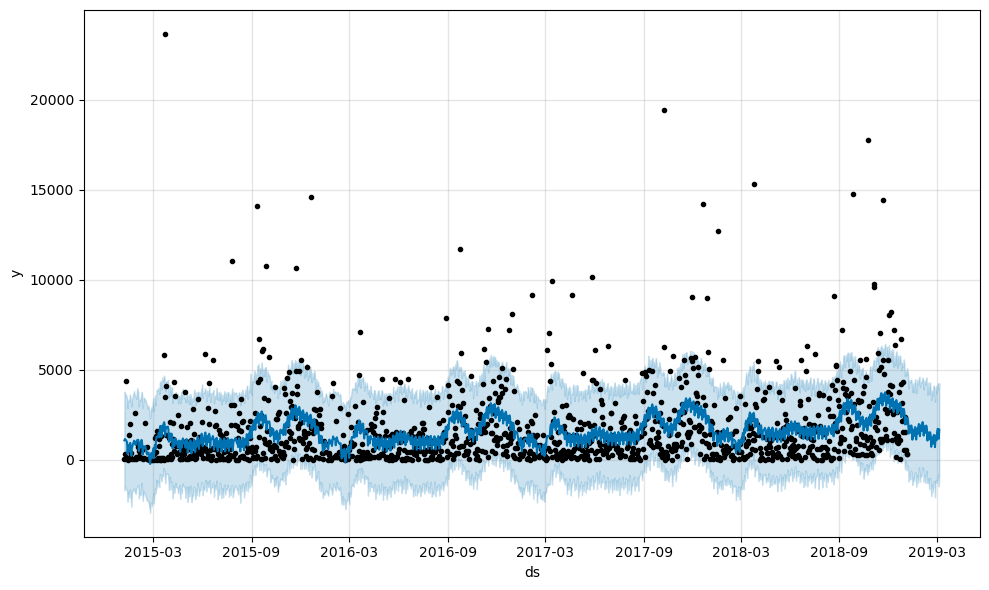

In [12]:
# plotting the predictions
plot_total = m.plot(forecast_total)

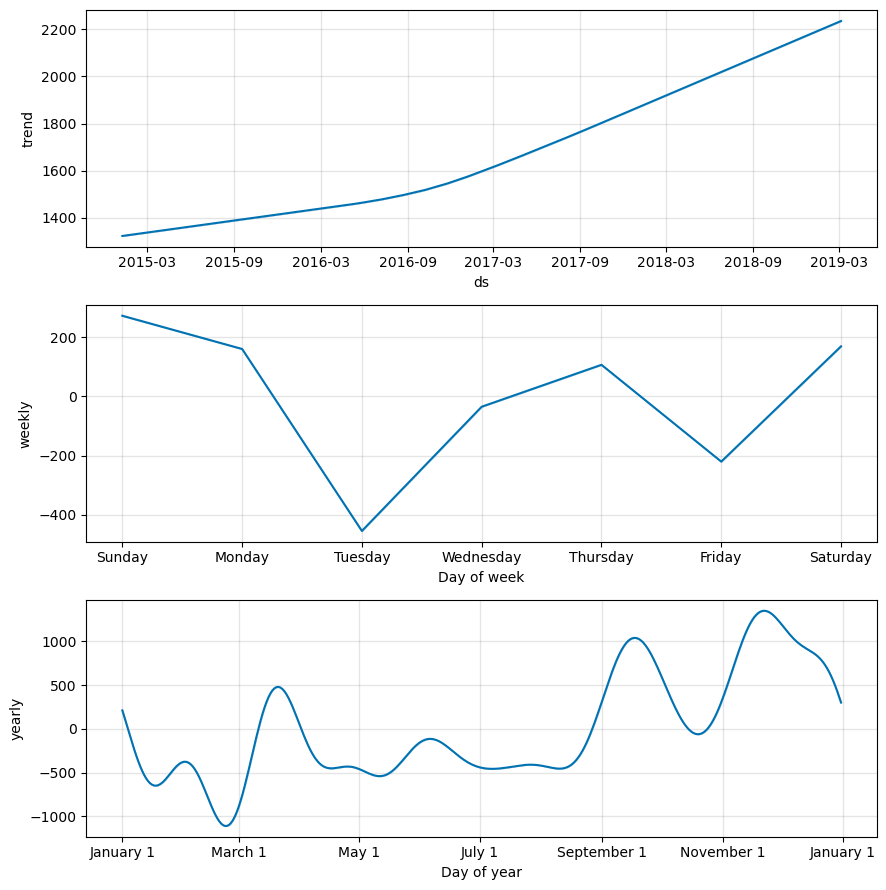

In [13]:
# plotting the various breakdowns of the predictions
plot_total2 = m.plot_components(forecast_total)

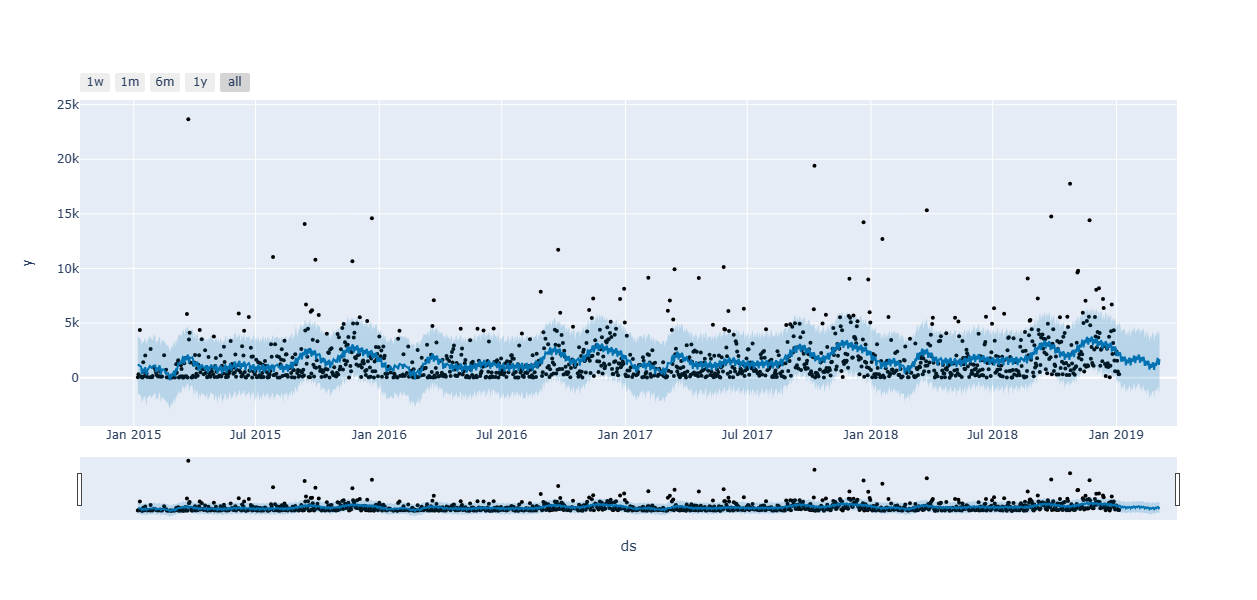

In [14]:
# another way of visualizing the predictions
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast_total)

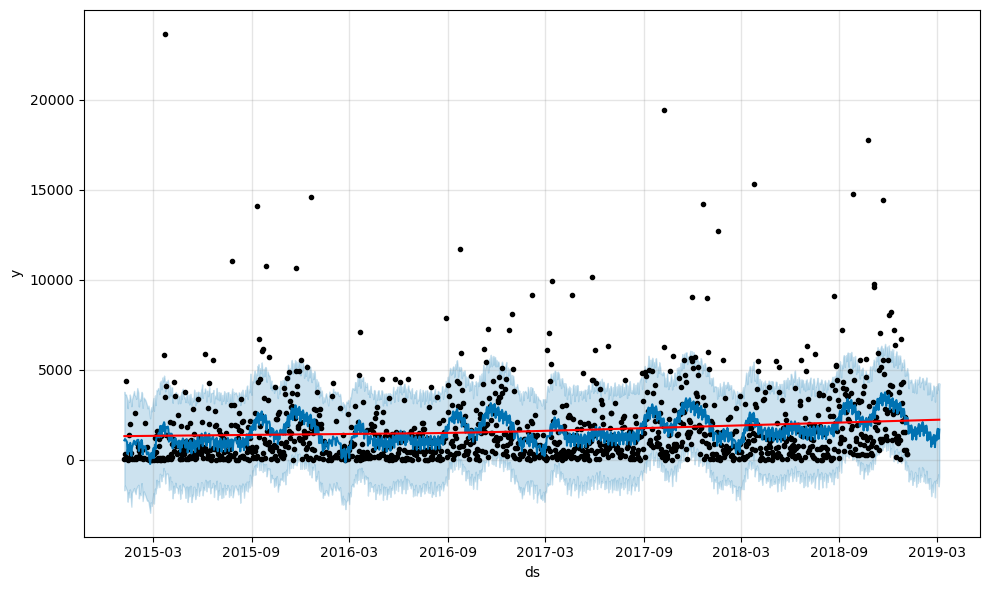

In [15]:
# understanding the changepoints in the predictions
from prophet.plot import add_changepoints_to_plot

fig = m.plot(forecast_total)
a = add_changepoints_to_plot(fig.gca(), m, forecast_total)

In [16]:
# performing cross validation of the model where y is the actual and yhat is the prediction
total_cv = cross_validation(m, initial = '730 days', period = '180 days', horizon = '60 days')
total_cv.head()

  0%|          | 0/4 [00:00<?, ?it/s]

15:08:33 - cmdstanpy - INFO - Chain [1] start processing
15:08:33 - cmdstanpy - INFO - Chain [1] done processing
15:08:33 - cmdstanpy - INFO - Chain [1] start processing
15:08:33 - cmdstanpy - INFO - Chain [1] done processing
15:08:33 - cmdstanpy - INFO - Chain [1] start processing
15:08:33 - cmdstanpy - INFO - Chain [1] done processing
15:08:34 - cmdstanpy - INFO - Chain [1] start processing
15:08:34 - cmdstanpy - INFO - Chain [1] done processing


ds         yhat   yhat_lower   yhat_upper         y     cutoff
0 2017-05-16   253.413511 -2328.654989  2378.988865   151.590 2017-05-15
1 2017-05-17   520.755164 -1888.607189  2778.499935   779.248 2017-05-15
2 2017-05-18   834.728723 -1310.130094  3168.630724   253.030 2017-05-15
3 2017-05-19   711.261169 -1703.088161  3126.929297   524.574 2017-05-15
4 2017-05-20  1205.704910 -1201.337894  3613.776812  2040.022 2017-05-15

In [17]:
# calculating the various performance metrics and have a look at the last 5 records
total_pm = performance_metrics(total_cv)
total_pm.tail()

horizon           mse         rmse          mae      mape     mdape  \
50 56 days  3.274632e+06  1809.594373  1250.037678  2.734654  0.385328   
51 57 days  2.650266e+06  1627.963643  1078.713194  2.630702  0.385328   
52 58 days  2.859806e+06  1691.096117  1171.481004  4.503982  0.609475   
53 59 days  2.460036e+06  1568.450240  1104.365850  3.390118  0.642932   
54 60 days  1.541567e+06  1241.598749   972.204442  3.546180  0.642932   

       smape  coverage  
50  0.646232  0.869565  
51  0.602475  0.913043  
52  0.718222  0.913043  
53  0.729173  0.934783  
54  0.723591  1.000000

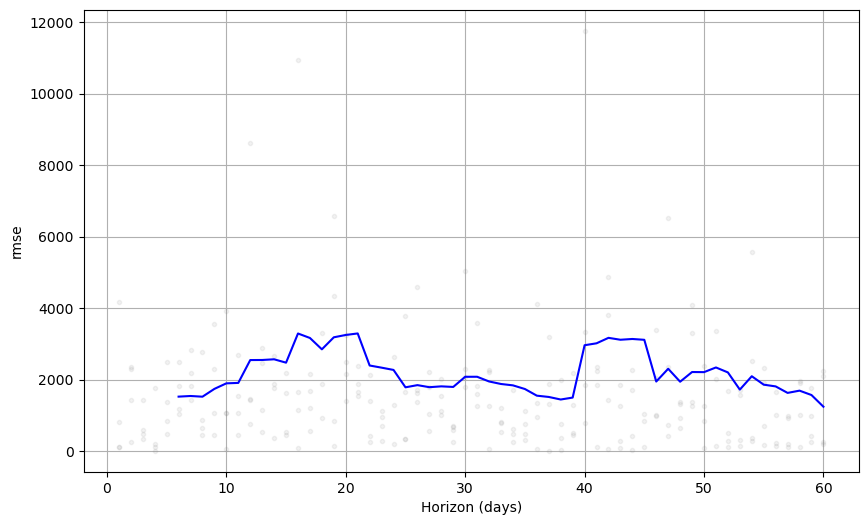

In [18]:
# plot a graph of the cross validations using the rsme (Root Squared Mean Error) 
fig = plot_cross_validation_metric(total_cv, metric = 'rmse')

In [19]:
# determine the forecast time frame
future_start = "2019-01-06"
future_end = "2019-01-19"

In [20]:
# create a new DF for the forecast period we are interested in (i.e. forecast time frame)
next_14_forecast_total = new_forecast_total.loc[(new_forecast_total.ds >= future_start) & (new_forecast_total.ds <= future_end)] 
next_14_forecast_total

ds   yhat_lower   yhat_upper         yhat
1326 2019-01-06  -300.974280  4902.840491  2330.343479
1327 2019-01-07  -462.431390  4787.732086  2145.890196
1328 2019-01-08 -1197.993386  3978.286836  1460.768726
1329 2019-01-09  -772.198424  4442.154657  1816.069934
1330 2019-01-10  -776.104538  4359.231498  1897.400901
1331 2019-01-11 -1087.618351  4307.953440  1514.714446
1332 2019-01-12  -591.389343  4451.671096  1855.995581
1333 2019-01-13  -624.984907  4464.645276  1917.425260
1334 2019-01-14  -907.920569  4216.578407  1770.059040
1335 2019-01-15 -1386.080735  3782.687105  1126.573697
1336 2019-01-16 -1146.156078  4148.758227  1527.263292
1337 2019-01-17  -986.193125  4253.949153  1656.830435
1338 2019-01-18 -1157.281360  3742.543012  1324.236372
1339 2019-01-19  -737.953163  4347.628015  1716.410636

In [21]:
# calculate the total forecasted value for the forecast time frame
next_14_forecast_total_sum = round(next_14_forecast_total['yhat'].sum())
print(f"The forecasted value based on all categories from 2019-01-06 to 2019-01-19 is: {next_14_forecast_total_sum}")

The forecasted value based on all categories from 2019-01-06 to 2019-01-19 is: 24060


# We will attempt to do the forecasting based on the 3 categories and then compare to the forecasted value based on totality as noted above (24,060)

In [22]:
# create a new DF based on ship date. category and sales
data1 = data[['Ship Date','Category','Sales']]
data1.sample(5)

Ship Date         Category     Sales
2277 2015-07-01        Furniture    85.980
5644 2018-03-26  Office Supplies    34.760
9359 2017-01-28        Furniture    45.980
35   2017-12-10       Technology  1097.544
5132 2016-06-27       Technology   107.976

In [23]:
# understand what are the available categories
data1['Category'].value_counts()

Office Supplies    5909
Furniture          2078
Technology         1813
Name: Category, dtype: int64

In [24]:
# filter the DF based on Office Supplies only
mask = (data1['Category'] == 'Office Supplies')
data1_os = data1[mask]
data1_os.head()

Ship Date         Category    Sales
2 2017-06-16  Office Supplies   14.620
4 2016-10-18  Office Supplies   22.368
6 2015-06-14  Office Supplies    7.280
8 2015-06-14  Office Supplies   18.504
9 2015-06-14  Office Supplies  114.900

In [25]:
# drop the now redundant Category column
data1_os.drop(columns=['Category'], axis=1, inplace=True)

In [26]:
#  as noted above, there are more than 1 transactions for 1 ship date (i.e. not unique), thus, we need to group the sales by ship date
data1_os_sales = data1_os.groupby(['Ship Date'], as_index=False, dropna=False).agg({'Sales':'sum'})
data1_os_sales.head()

Ship Date    Sales
0 2015-01-07   29.228
1 2015-01-08  307.500
2 2015-01-10  653.120
3 2015-01-12   29.966
4 2015-01-13    9.344

In [27]:
# rename the columns as required by FBProphet
data1_os_sales.columns = ['ds', 'y']
data1_os_sales.tail(3)

ds        y
1239 2019-01-03  155.208
1240 2019-01-04  329.374
1241 2019-01-05  209.300

In [28]:
# create and fit the model to the DF
m = Prophet()
model_os = m.fit(data1_os_sales)

15:09:52 - cmdstanpy - INFO - Chain [1] start processing
15:09:52 - cmdstanpy - INFO - Chain [1] done processing


In [29]:
# making predictions into the future and have a look at the 1st 5 predictions
future_os = m.make_future_dataframe(periods = 60, freq = 'D')
forecast_os = m.predict(future_os)
forecast_os.head()

ds       trend  yhat_lower   yhat_upper  trend_lower  trend_upper  \
0 2015-01-07  455.021777 -800.531532  1578.605060   455.021777   455.021777   
1 2015-01-08  455.056392 -632.771379  1636.248225   455.056392   455.056392   
2 2015-01-10  455.125623 -684.422532  1663.650280   455.125623   455.125623   
3 2015-01-12  455.194854 -754.496410  1678.509070   455.194854   455.194854   
4 2015-01-13  455.229469 -930.385065  1447.892355   455.229469   455.229469   

   additive_terms  additive_terms_lower  additive_terms_upper      weekly  \
0      -46.593609            -46.593609            -46.593609  -26.807584   
1       37.368316             37.368316             37.368316   62.222653   
2       29.439643             29.439643             29.439643   60.748340   
3      -41.111919            -41.111919            -41.111919   -7.767200   
4     -167.044935           -167.044935           -167.044935 -134.047366   

   weekly_lower  weekly_upper     yearly  yearly_lower  yearly_upper  \
0    -26.807584    -26.807584 -19.786025    -19.786025    -19.786025   
1     62.222653     62.222653 -24.854336    -24.854336    -24.854336   
2     60.748340     60.748340 -31.308696    -31.308696    -31.308696   
3     -7.767200     -7.767200 -33.344720    -33.344720    -33.344720   
4   -134.047366   -134.047366 -32.997569    -32.997569    -32.997569   

   multiplicative_terms  multiplicative_terms_lower  \
0                   0.0                         0.0   
1                   0.0                         0.0   
2                   0.0                         0.0   
3                   0.0                         0.0   
4                   0.0                         0.0   

   multiplicative_terms_upper        yhat  
0                         0.0  408.428168  
1                         0.0  492.424708  
2                         0.0  484.565266  
3                         0.0  414.082935  
4                         0.0  288.184534

In [30]:
# create a new DF to store relevant information about the predictions (yhat = prediction, yhat_lower and yhat_upper are the lower and upper bound / confidence levels of the predictions) & have a look at the ;last 5 records
new_forecast_os = forecast_os[['ds','yhat','yhat_lower','yhat_upper']]
new_forecast_os.tail(3)

ds        yhat  yhat_lower   yhat_upper
1299 2019-03-04  702.158722 -573.498649  1936.406406
1300 2019-03-05  596.056680 -493.113692  1823.621531
1301 2019-03-06  722.425201 -513.795922  1900.833670

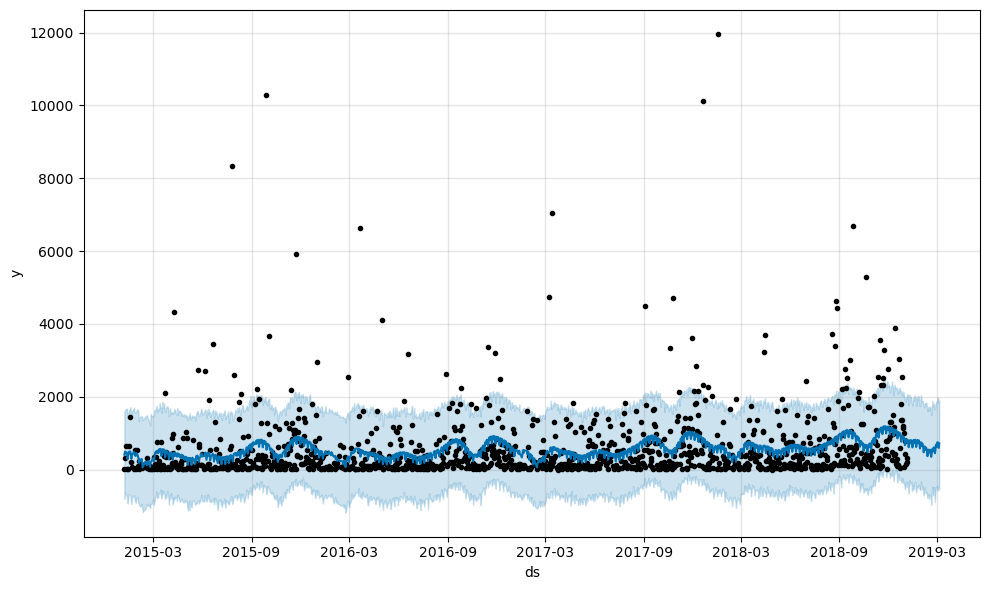

In [31]:
# plotting the forecast
plot_os = m.plot(forecast_os)

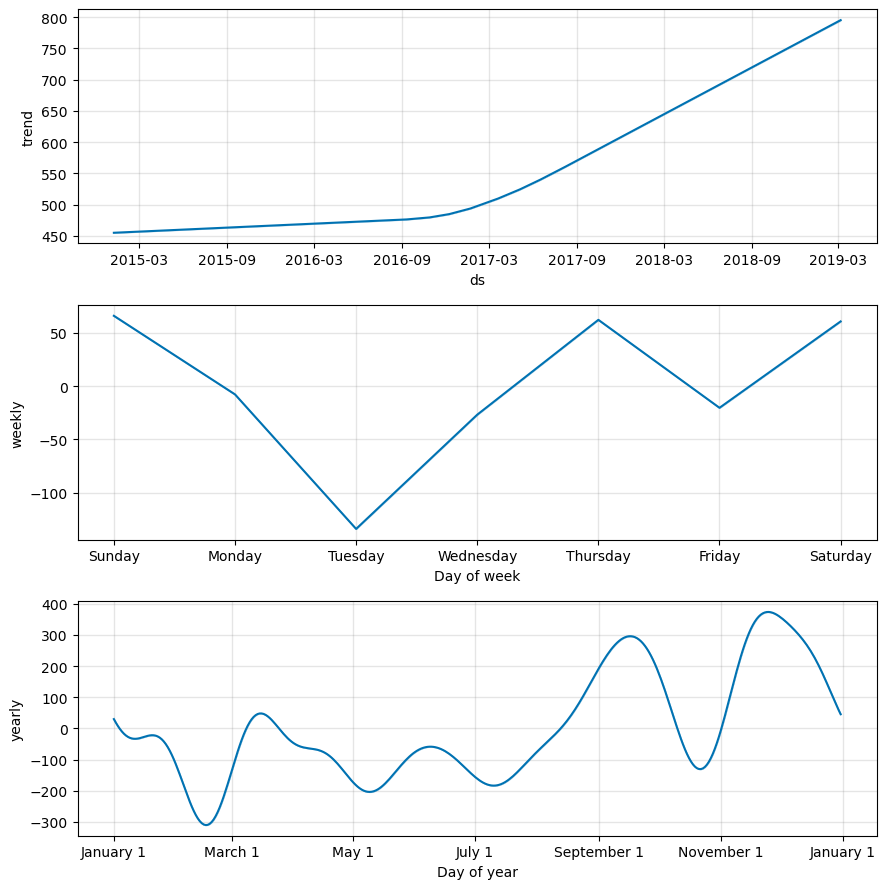

In [32]:
# plotting the various breakdowns of the predictions for Office Supplies Category
plot2_os = m.plot_components(forecast_os)

In [33]:
# performing cross validation of the model where y is the actual and yhat is the prediction for Office Supplies Category
os_cv = cross_validation(m, initial = '730 days', period = '180 days', horizon = '60 days')
os_cv.head()

  0%|          | 0/4 [00:00<?, ?it/s]

15:10:09 - cmdstanpy - INFO - Chain [1] start processing
15:10:09 - cmdstanpy - INFO - Chain [1] done processing
15:10:10 - cmdstanpy - INFO - Chain [1] start processing
15:10:10 - cmdstanpy - INFO - Chain [1] done processing
15:10:10 - cmdstanpy - INFO - Chain [1] start processing
15:10:10 - cmdstanpy - INFO - Chain [1] done processing
15:10:10 - cmdstanpy - INFO - Chain [1] start processing
15:10:10 - cmdstanpy - INFO - Chain [1] done processing


ds        yhat  yhat_lower   yhat_upper        y     cutoff
0 2017-05-16  165.489610 -968.237555  1319.973387   31.590 2017-05-15
1 2017-05-17  241.411879 -875.390377  1343.623997  137.268 2017-05-15
2 2017-05-18  225.390856 -853.764264  1286.424845   79.790 2017-05-15
3 2017-05-19  176.100888 -939.761555  1272.669153  167.942 2017-05-15
4 2017-05-20  292.974396 -815.829088  1330.073858  653.454 2017-05-15

In [34]:
# calculating the various performance metrics and have a look at the last 5 records
os_pm = performance_metrics(os_cv)
os_pm.tail()

horizon            mse        rmse         mae      mape     mdape  \
50 56 days  384925.603732  620.423729  438.807380  4.830757  0.681735   
51 57 days  295883.725902  543.951952  395.750539  2.343891  0.732785   
52 58 days  314618.896639  560.908991  418.851588  2.908552  0.744484   
53 59 days  281604.806496  530.664495  376.083626  2.409362  0.732785   
54 60 days  255754.058993  505.721325  366.386992  2.144762  0.732785   

       smape  coverage  
50  0.868036  0.939394  
51  0.830272  0.954545  
52  0.916975  0.954545  
53  0.818028  0.954545  
54  0.821794  0.954545

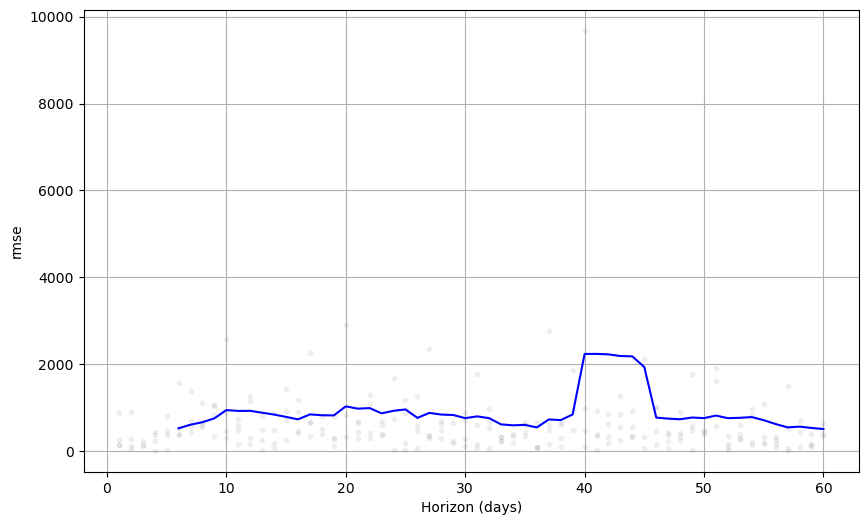

In [35]:
# plot a graph of the cross validations using the rsme (Root Squared Mean Error) 
fig = plot_cross_validation_metric(os_cv, metric = 'rmse')

In [36]:
# create a new DF for the forecast period we are interested in (i.e. forecast time frame)
next_14_forecast_os = new_forecast_os.loc[(new_forecast_os.ds >= future_start) & (new_forecast_os.ds <= future_end)] 
next_14_forecast_os.head()

ds        yhat  yhat_lower   yhat_upper
1242 2019-01-06  823.714491 -407.345424  2030.487730
1243 2019-01-07  744.010447 -476.937360  2050.254966
1244 2019-01-08  613.069643 -654.268774  1772.709799
1245 2019-01-09  716.893353 -441.962460  1892.789973
1246 2019-01-10  803.700651 -289.254760  2058.495887

In [37]:
# calculate the total forecasted value for the forecast time frame
next_14_forecast_os_sum = round(next_14_forecast_os['yhat'].sum())
print(f"The forecasted value based on Office Supplies Category only from 2019-01-06 to 2019-01-19 is: {next_14_forecast_os_sum}")

The forecasted value based on Office Supplies Category only from 2019-01-06 to 2019-01-19 is: 10451


In [38]:
# we will repeat the process for the Furniture Category
mask1 = (data1['Category'] == 'Furniture')
data1_fur = data1[mask1]
data1_fur.head()

Ship Date   Category      Sales
0  2017-11-11  Furniture   261.9600
1  2017-11-11  Furniture   731.9400
3  2016-10-18  Furniture   957.5775
5  2015-06-14  Furniture    48.8600
10 2015-06-14  Furniture  1706.1840

In [39]:
# dropping the Category column
data1_fur.drop(columns=['Category'], axis=1, inplace=True)
data1_fur.sample(3)

Ship Date    Sales
9402 2017-08-17  209.148
8502 2016-03-03  184.752
7186 2018-08-24   74.592

In [40]:
# group the sales by ship date
data1_fur_sales = data1_fur.groupby(['Ship Date'], as_index=False, dropna=False).agg({'Sales':'sum'})
data1_fur_sales.head()

Ship Date     Sales
0 2015-01-10  2573.820
1 2015-01-12    76.728
2 2015-01-14     9.940
3 2015-01-15   113.900
4 2015-01-16   545.940

In [41]:
# rename the columns as required by FBProphet
data1_fur_sales.columns = ['ds', 'y']
data1_fur_sales.tail()

ds          y
944 2018-12-31  1191.6240
945 2019-01-01  1970.7228
946 2019-01-02   469.4280
947 2019-01-03   323.1360
948 2019-01-05   101.1200

In [42]:
# create and fit the model to Furniture DF
m = Prophet()
model_fur = m.fit(data1_fur_sales)

15:10:35 - cmdstanpy - INFO - Chain [1] start processing
15:10:35 - cmdstanpy - INFO - Chain [1] done processing


In [43]:
# making predictions into the future and have a look at the 1st 5 predictions
future_fur = m.make_future_dataframe(periods = 60, freq = 'D')
forecast_fur = m.predict(future_fur)
forecast_fur.head()

ds       trend  yhat_lower   yhat_upper  trend_lower  trend_upper  \
0 2015-01-10  664.909272 -444.366725  1839.085130   664.909272   664.909272   
1 2015-01-12  665.058846 -457.605727  1847.140792   665.058846   665.058846   
2 2015-01-14  665.208420 -529.492162  1782.658718   665.208420   665.208420   
3 2015-01-15  665.283207 -568.723999  1816.667041   665.283207   665.283207   
4 2015-01-16  665.357994 -522.312254  1664.547881   665.357994   665.357994   

   additive_terms  additive_terms_lower  additive_terms_upper     weekly  \
0       14.416900             14.416900             14.416900  46.993385   
1       15.099908             15.099908             15.099908  65.583322   
2      -71.924320            -71.924320            -71.924320  -4.354785   
3      -34.406256            -34.406256            -34.406256  41.703493   
4     -112.087657           -112.087657           -112.087657 -27.326930   

   weekly_lower  weekly_upper     yearly  yearly_lower  yearly_upper  \
0     46.993385     46.993385 -32.576486    -32.576486    -32.576486   
1     65.583322     65.583322 -50.483415    -50.483415    -50.483415   
2     -4.354785     -4.354785 -67.569535    -67.569535    -67.569535   
3     41.703493     41.703493 -76.109749    -76.109749    -76.109749   
4    -27.326930    -27.326930 -84.760727    -84.760727    -84.760727   

   multiplicative_terms  multiplicative_terms_lower  \
0                   0.0                         0.0   
1                   0.0                         0.0   
2                   0.0                         0.0   
3                   0.0                         0.0   
4                   0.0                         0.0   

   multiplicative_terms_upper        yhat  
0                         0.0  679.326172  
1                         0.0  680.158753  
2                         0.0  593.284099  
3                         0.0  630.876950  
4                         0.0  553.270337

In [44]:
# create a new DF to store relevant information about the predictions (yhat = prediction, yhat_lower and yhat_upper are the lower and upper bound / confidence levels of the predictions) & have a look at the last 5 records
new_forecast_fur = forecast_fur[['ds','yhat_lower','yhat_upper','yhat']]
new_forecast_fur.tail(3)

ds  yhat_lower   yhat_upper        yhat
1006 2019-03-04 -599.438450  1788.468955  582.494263
1007 2019-03-05 -854.168967  1470.908440  317.508807
1008 2019-03-06 -703.806822  1678.786661  522.237666

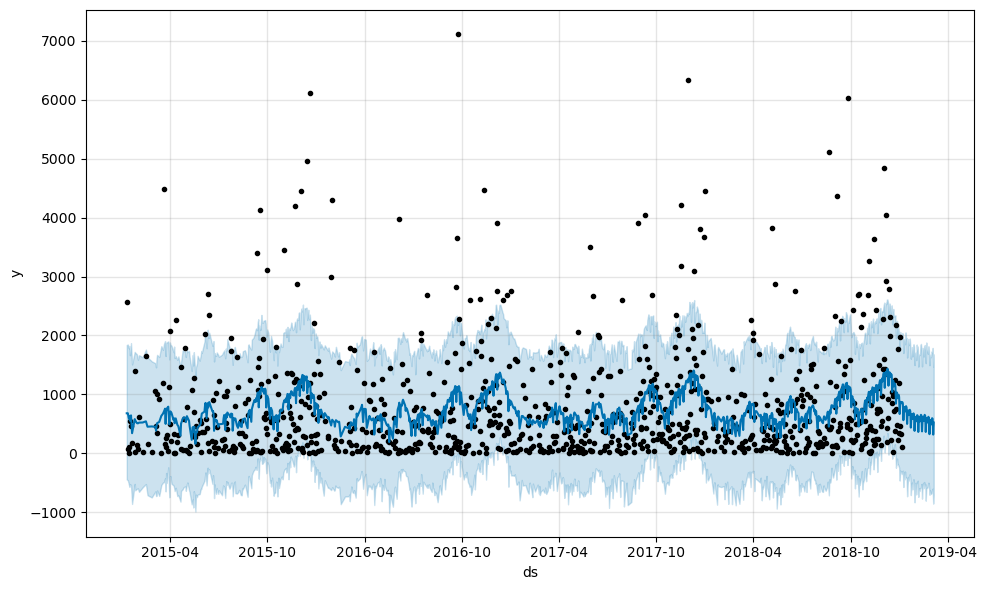

In [45]:
# plotting the forecast for Furniture category
plot_fur = m.plot(forecast_fur)

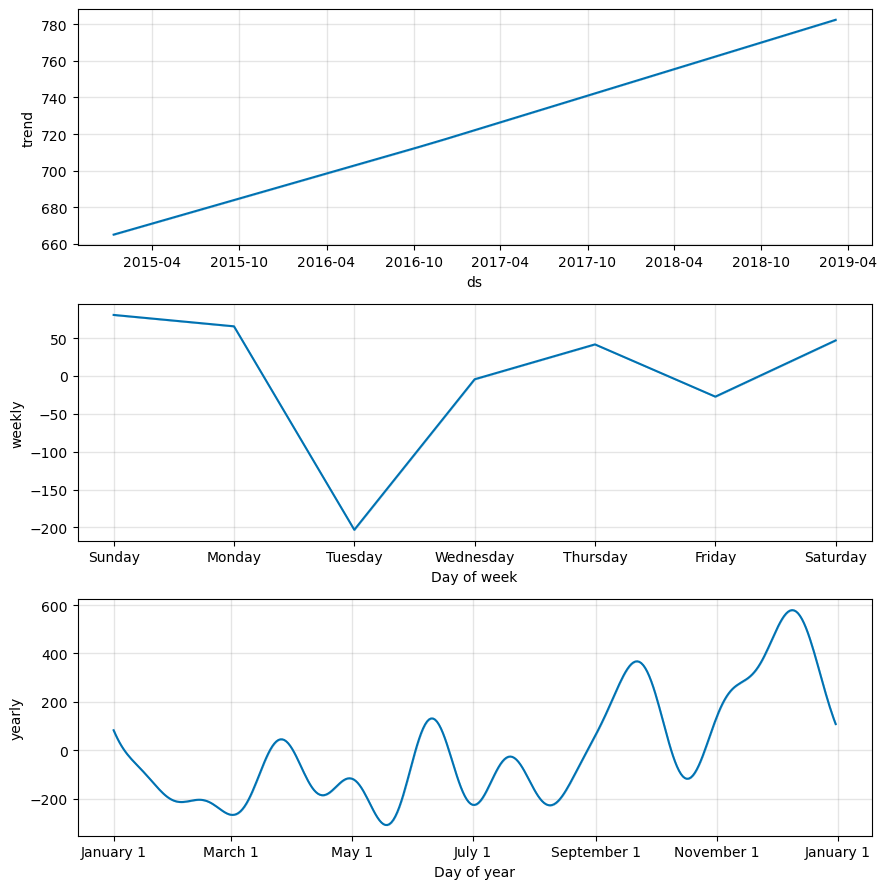

In [46]:
# plotting the various breakdowns of the predictions for Furniture Category
plot2_fur = m.plot_components(forecast_fur)

In [47]:
# performing cross validation of the model where y is the actual and yhat is the prediction for Furniture Category
fur_cv = cross_validation(m, initial = '730 days', period = '180 days', horizon = '60 days')
fur_cv.head()

  0%|          | 0/4 [00:00<?, ?it/s]

15:10:57 - cmdstanpy - INFO - Chain [1] start processing
15:10:57 - cmdstanpy - INFO - Chain [1] done processing
15:10:57 - cmdstanpy - INFO - Chain [1] start processing
15:10:57 - cmdstanpy - INFO - Chain [1] done processing
15:10:57 - cmdstanpy - INFO - Chain [1] start processing
15:10:57 - cmdstanpy - INFO - Chain [1] done processing
15:10:58 - cmdstanpy - INFO - Chain [1] start processing
15:10:58 - cmdstanpy - INFO - Chain [1] done processing


ds        yhat  yhat_lower   yhat_upper        y     cutoff
0 2017-05-17  200.889695 -873.594794  1295.647289   10.020 2017-05-15
1 2017-05-18  343.723865 -748.126992  1453.431542  173.240 2017-05-15
2 2017-05-19  346.627442 -722.772393  1492.297812  313.032 2017-05-15
3 2017-05-20  537.854982 -436.209655  1721.190219   22.608 2017-05-15
4 2017-05-24  364.509912 -745.557510  1493.516780  717.640 2017-05-15

In [48]:
# calculating the various performance metrics and have a look at the last 5 records
fur_pm = performance_metrics(fur_cv)
fur_pm.tail()

horizon            mse        rmse         mae      mape     mdape  \
51 56 days  632762.864698  795.463930  646.032830  1.764260  0.640744   
52 57 days  380882.544014  617.156823  534.695929  1.623939  0.632726   
53 58 days  332689.906507  576.792776  495.092455  2.890916  0.640072   
54 59 days  309892.446333  556.679842  466.571980  2.872225  0.640072   
55 60 days  321471.252468  566.984349  477.926148  3.535903  0.976108   

       smape  coverage  
51  0.834502  0.881579  
52  0.751368  0.929825  
53  0.786791  0.947368  
54  0.757222  0.947368  
55  0.835630  0.947368

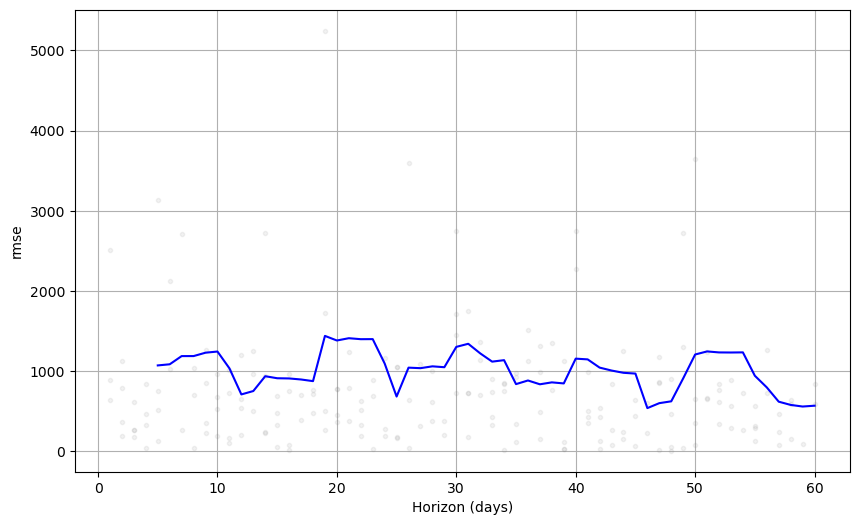

In [49]:
# plot a graph of the cross validations using the rsme (Root Squared Mean Error) 
fig = plot_cross_validation_metric(fur_cv, metric = 'rmse')

In [50]:
# create a new DF for the forecast period we are interested in (i.e. forecast time frame)
next_14_forecast_fur = new_forecast_fur.loc[(new_forecast_fur.ds >= future_start) & (new_forecast_fur.ds <= future_end)] 
next_14_forecast_fur.head()

ds  yhat_lower   yhat_upper        yhat
949 2019-01-06 -305.630307  2040.461912  869.296694
950 2019-01-07 -295.782164  2027.429368  842.103562
951 2019-01-08 -571.850862  1703.924709  562.180581
952 2019-01-09 -316.269275  1917.187642  750.811182
953 2019-01-10 -445.635264  1937.289379  787.308991

In [51]:
# calculate the total forecasted value for the forecast time frame
next_14_forecast_fur_sum = round(next_14_forecast_fur['yhat'].sum())
print(f"The forecasted value based on Furniture Category only from 2019-01-06 to 2019-01-19 is: {next_14_forecast_fur_sum}")

The forecasted value based on Furniture Category only from 2019-01-06 to 2019-01-19 is: 10151


In [52]:
# let's do for the final category: Technology
mask2 = (data1['Category'] == 'Technology')
data1_tech = data1[mask2]
data1_tech.head()

Ship Date    Category     Sales
7  2015-06-14  Technology   907.152
11 2015-06-14  Technology   911.424
19 2015-09-01  Technology   213.480
26 2017-01-20  Technology    90.570
35 2017-12-10  Technology  1097.544

In [53]:
# dropping column that is required for the model
data1_tech.drop(columns=['Category'], axis=1, inplace=True)
data1_tech.sample(3)

Ship Date    Sales
375  2015-07-27  479.040
3305 2016-01-01  217.584
8096 2018-08-01  234.950

In [54]:
# group sales by ship date
data1_tech_sales = data1_tech.groupby(['Ship Date'], as_index=False, dropna=False).agg({'Sales':'sum'})
data1_tech_sales.head()

Ship Date    Sales
0 2015-01-10  1147.94
1 2015-01-13    31.20
2 2015-01-15   646.74
3 2015-01-17   149.95
4 2015-01-18   124.20

In [55]:
# rename column names as per model requirements
data1_tech_sales.columns = ['ds', 'y']
data1_tech_sales.tail()

ds        y
865 2018-12-29  122.280
866 2018-12-30  158.928
867 2019-01-02  302.376
868 2019-01-03   90.930
869 2019-01-04   14.850

In [56]:
# initialize and fit the model
m = Prophet()
model_tech = m.fit(data1_tech_sales)

15:12:03 - cmdstanpy - INFO - Chain [1] start processing
15:12:03 - cmdstanpy - INFO - Chain [1] done processing


In [57]:
# making predictions into the future and have a look at the 1st 5 predictions
future_tech = m.make_future_dataframe(periods = 60, freq = 'D')
forecast_tech = m.predict(future_tech)
forecast_tech.head()

ds       trend   yhat_lower   yhat_upper  trend_lower  trend_upper  \
0 2015-01-10  885.036622 -1505.514574  2719.055475   885.036622   885.036622   
1 2015-01-13  884.683991 -1885.399148  2349.120048   884.683991   884.683991   
2 2015-01-15  884.448904 -1787.039515  2509.740081   884.448904   884.448904   
3 2015-01-17  884.213817 -1541.907463  2460.798829   884.213817   884.213817   
4 2015-01-18  884.096273 -1390.894173  2793.647512   884.096273   884.096273   

   additive_terms  additive_terms_lower  additive_terms_upper      weekly  \
0     -296.347553           -296.347553           -296.347553   11.202193   
1     -595.081638           -595.081638           -595.081638 -184.669073   
2     -503.616418           -503.616418           -503.616418  -63.654230   
3     -422.331961           -422.331961           -422.331961   11.202193   
4     -185.314930           -185.314930           -185.314930  231.337344   

   weekly_lower  weekly_upper      yearly  yearly_lower  yearly_upper  \
0     11.202193     11.202193 -307.549746   -307.549746   -307.549746   
1   -184.669073   -184.669073 -410.412565   -410.412565   -410.412565   
2    -63.654230    -63.654230 -439.962188   -439.962188   -439.962188   
3     11.202193     11.202193 -433.534153   -433.534153   -433.534153   
4    231.337344    231.337344 -416.652274   -416.652274   -416.652274   

   multiplicative_terms  multiplicative_terms_lower  \
0                   0.0                         0.0   
1                   0.0                         0.0   
2                   0.0                         0.0   
3                   0.0                         0.0   
4                   0.0                         0.0   

   multiplicative_terms_upper        yhat  
0                         0.0  588.689069  
1                         0.0  289.602353  
2                         0.0  380.832486  
3                         0.0  461.881856  
4                         0.0  698.781343

In [58]:
# create a new DF to store relevant information about the predictions (yhat = prediction, yhat_lower and yhat_upper are the lower and upper bound / confidence levels of the predictions) & have a look at the last 5 records
new_forecast_tech = forecast_tech[['ds','yhat_lower', 'yhat_upper','yhat']]
new_forecast_tech.tail(3)

ds   yhat_lower   yhat_upper         yhat
927 2019-03-03 -1365.409899  2902.809682   838.256778
928 2019-03-04  -975.371945  3143.342329  1021.752502
929 2019-03-05 -1674.984359  2714.357002   610.153725

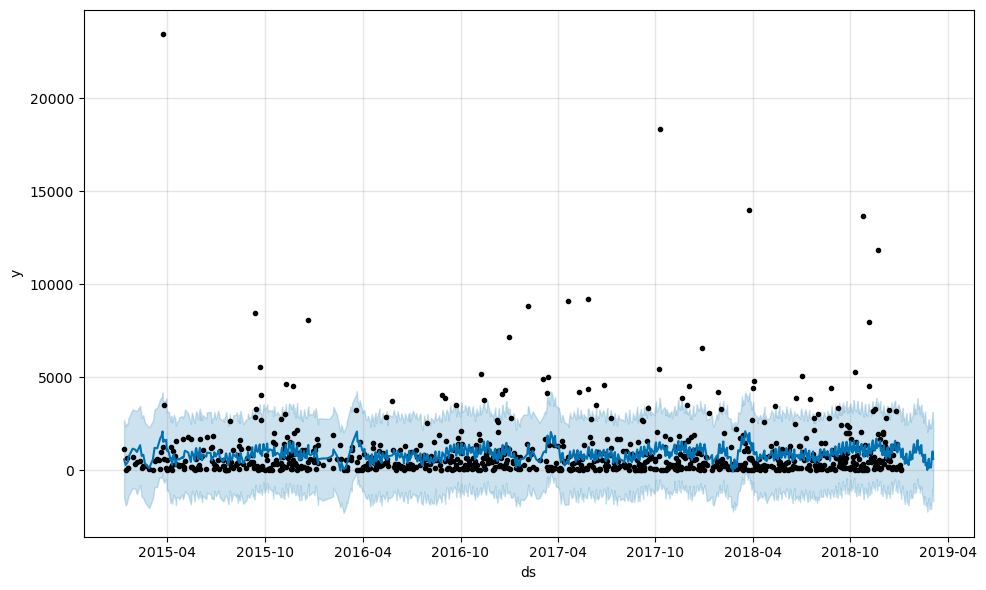

In [59]:
# plotting the forecast
plot_tech = m.plot(forecast_tech)

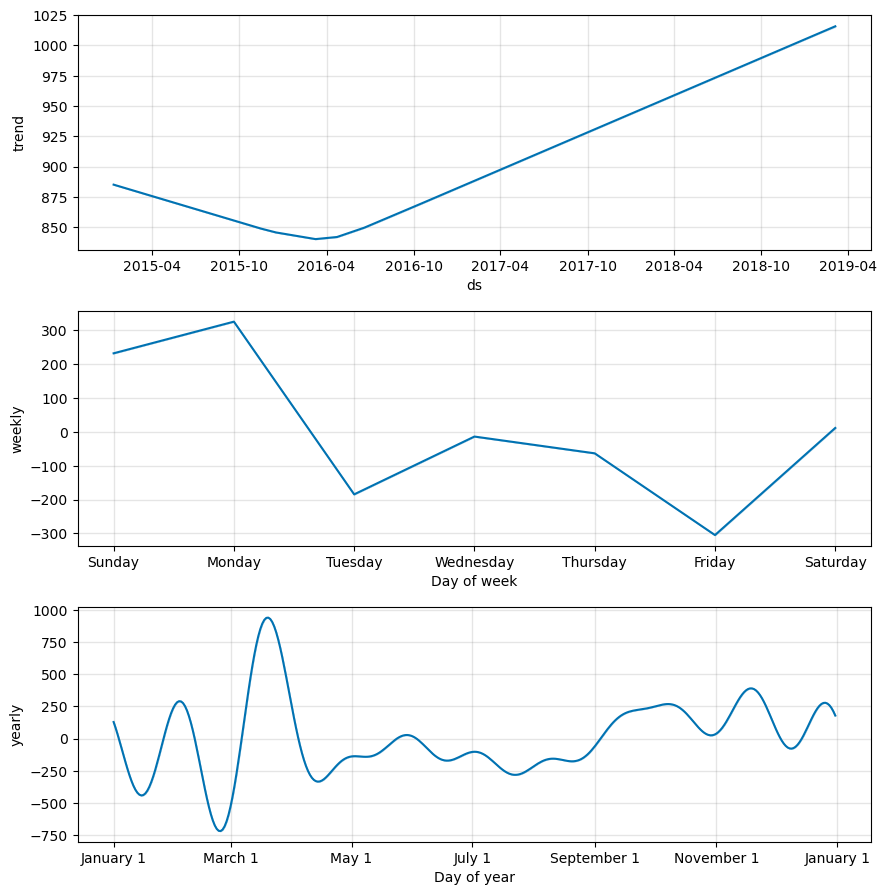

In [60]:
# plotting the components of the forecast
plot2_tech = m.plot_components(forecast_tech)

In [61]:
# performing cross validation of the model where y is the actual and yhat is the prediction for Furniture Category
tech_cv = cross_validation(m, initial = '730 days', period = '180 days', horizon = '60 days')
tech_cv.head()

  0%|          | 0/4 [00:00<?, ?it/s]

15:12:14 - cmdstanpy - INFO - Chain [1] start processing
15:12:14 - cmdstanpy - INFO - Chain [1] done processing
15:12:14 - cmdstanpy - INFO - Chain [1] start processing
15:12:14 - cmdstanpy - INFO - Chain [1] done processing
15:12:15 - cmdstanpy - INFO - Chain [1] start processing
15:12:15 - cmdstanpy - INFO - Chain [1] done processing
15:12:15 - cmdstanpy - INFO - Chain [1] start processing
15:12:15 - cmdstanpy - INFO - Chain [1] done processing


ds        yhat   yhat_lower   yhat_upper         y     cutoff
0 2017-05-16  302.105967 -1601.685818  2321.571446   120.000 2017-05-14
1 2017-05-17  401.045330 -1587.816299  2466.011507   631.960 2017-05-14
2 2017-05-19  413.928589 -1589.020521  2457.998615    43.600 2017-05-14
3 2017-05-20  811.530216 -1208.260466  2724.852291  1363.960 2017-05-14
4 2017-05-23  412.000348 -1658.612629  2278.803023   121.436 2017-05-14

In [62]:
# calculating the various performance metrics and have a look at the first 5 records
tech_pm = performance_metrics(tech_cv)
tech_pm.head()

horizon            mse        rmse         mae      mape     mdape  \
0  6 days  822436.746058  906.882984  708.716324  6.095529  0.838185   
1  7 days  956673.873805  978.097068  788.594115  6.516489  1.046985   
2  8 days  889658.636988  943.217174  757.697446  6.750306  0.796801   
3  9 days  881657.413490  938.966141  746.439016  7.360705  0.874766   
4 10 days  910313.295648  954.103399  766.401461  7.809977  1.216836   

      smape  coverage  
0  0.845724  0.944444  
1  0.888771  0.944444  
2  0.866890  0.958333  
3  0.908894  0.944444  
4  0.943749  0.944444

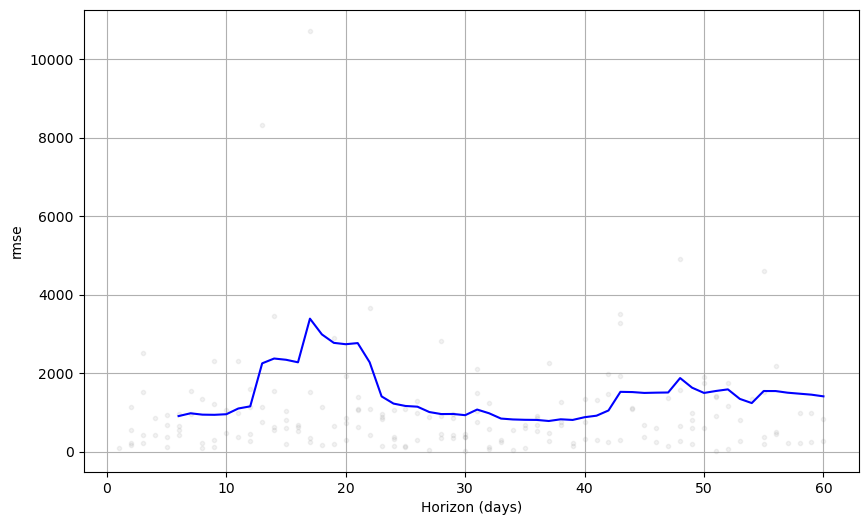

In [63]:
# plot a graph of the cross validations using the rsme (Root Squared Mean Error) 
fig = plot_cross_validation_metric(tech_cv, metric = 'rmse')

In [64]:
# create a new DF for the forecast period we are interested in (i.e. forecast time frame)
next_14_forecast_tech = new_forecast_tech.loc[(new_forecast_tech.ds >= future_start) & (new_forecast_tech.ds <= future_end)] 
next_14_forecast_tech.head()

ds   yhat_lower   yhat_upper         yhat
871 2019-01-06  -975.679655  3202.122805  1134.875879
872 2019-01-07  -823.134596  3366.904374  1173.518038
873 2019-01-08 -1321.202990  2724.771437   610.955164
874 2019-01-09 -1365.150129  2878.416713   731.113722
875 2019-01-10 -1632.655027  2754.776229   635.460958

In [65]:
# calculate the total forecasted value for the forecast time frame
next_14_forecast_tech_sum = round(next_14_forecast_tech['yhat'].sum())
print(f"The forecasted value based on Technology Category only from 2019-01-06 to 2019-01-19 is: {next_14_forecast_tech_sum}")

The forecasted value based on Technology Category only from 2019-01-06 to 2019-01-19 is: 9366


In [66]:
# compute the total based on individual categories and the calculate the difference with the total forecast
next_14_forecast_all_sum = round(next_14_forecast_os_sum + next_14_forecast_fur_sum + next_14_forecast_tech_sum)
diff_total_indiv = ((next_14_forecast_total_sum) - (next_14_forecast_all_sum))
print(f"The forecasted value based on Totality from 2019-01-06 to 2019-01-19 is: {next_14_forecast_total_sum}")
print(f"The forecasted value based on the 3 Categories from 2019-01-06 to 2019-01-19 is: {next_14_forecast_all_sum}")
print(f"The resulting difference between Totality Forecast and Combining Individual Category Forecasts for the period from 2019-01-06 to 2019-01-19 is: {diff_total_indiv}")

The forecasted value based on Totality from 2019-01-06 to 2019-01-19 is: 24060
The forecasted value based on the 3 Categories from 2019-01-06 to 2019-01-19 is: 29968
The resulting difference between Totality Forecast and Combining Individual Category Forecasts for the period from 2019-01-06 to 2019-01-19 is: -5908


# Supplementary Information

In [67]:
# knowing the setup of the model
m.component_modes

{'additive': ['yearly',
  'weekly',
  'additive_terms',
  'extra_regressors_additive',
  'holidays'],
 'multiplicative': ['multiplicative_terms', 'extra_regressors_multiplicative']}

In [68]:
# understanding the parameters
dir(Prophet)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_load_stan_backend',
 '_logistic_uncertainty',
 '_make_historical_mat_time',
 '_make_trend_shift_matrix',
 '_sample_uncertainty',
 'add_country_holidays',
 'add_group_component',
 'add_regressor',
 'add_seasonality',
 'construct_holiday_dataframe',
 'fit',
 'flat_growth_init',
 'flat_trend',
 'fourier_series',
 'initialize_scales',
 'linear_growth_init',
 'logistic_growth_init',
 'make_all_seasonality_features',
 'make_future_dataframe',
 'make_holiday_features',
 'make_seasonality_features',
 'parse_seasonality_args',
 'percentile',
 'piecewise_linear',
 'piecewise_logistic',
 'plot',
 'plot_components'